# 02 — Exploratory Data Analysis (LEGO Sets)

Goal: understand the structure and trends of LEGO sets to inform **feature engineering** for price prediction (BrickWorth).

**We’ll cover:**
1) Data overview & cleanliness
2) Univariate views (year, num_parts, themes)
3) Bivariate relationships (year ↔ parts, theme ↔ parts)
4) Simple statistical tests to support claims
5) Short list of features to engineer next

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")

# Robust root detection if notebook opened from /notebooks
CWD = Path.cwd()
PROJ = CWD if (CWD / "data").exists() else CWD.parent
RAW = PROJ / "data" / "raw"

SETS = RAW / "rebrickable_sets_all.csv"
THEMES = RAW / "rebrickable_themes.csv"

sets_df = pd.read_csv(SETS)
themes_df = pd.read_csv(THEMES)

df = sets_df.merge(themes_df, left_on="theme_id", right_on="id", how="left", suffixes=("_set","_theme"))
df = df.rename(columns={"name_set": "set_name", "name_theme": "theme_name"})

print("Rows:", len(df), "| Columns:", df.shape[1])
df.head(3)

Rows: 22955 | Columns: 11


,set_num,set_name,year,theme_id,num_parts,set_img_url,set_url,last_modified_dt,id,parent_id,theme_name
0,0003977811-1,Ninjago: Book of Adventures,2022,761,1,https://cdn.rebrickable.com/media/sets/0003977...,https://rebrickable.com/sets/0003977811-1/ninj...,2024-01-24T19:20:15.546851Z,761,497.0,Activity Books with LEGO Parts
1,010423-1,The Majestic Horse,2023,721,492,https://cdn.rebrickable.com/media/sets/010423-...,https://rebrickable.com/sets/010423-1/the-maje...,2023-04-03T14:52:47.187291Z,721,NaN,Icons
2,0241187567-1,Ninjago: Build Your Own Adventure,2015,761,74,https://cdn.rebrickable.com/media/sets/0241187...,https://rebrickable.com/sets/0241187567-1/ninj...,2024-01-21T22:47:20.815654Z,761,497.0,Activity Books with LEGO Parts


## 1) Data health checks
We need column types, missingness, and basic ranges to avoid garbage‑in later.

In [2]:
df.info()
na = df.isna().sum().sort_values(ascending=False)
na[na>0].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22955 entries, 0 to 22954
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   set_num           22955 non-null  object 
 1   set_name          22955 non-null  object 
 2   year              22955 non-null  int64  
 3   theme_id          22955 non-null  int64  
 4   num_parts         22955 non-null  int64  
 5   set_img_url       22344 non-null  object 
 6   set_url           22955 non-null  object 
 7   last_modified_dt  22955 non-null  object 
 8   id                22955 non-null  int64  
 9   parent_id         13466 non-null  float64
 10  theme_name        22955 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 1.9+ MB


parent_id      9489
set_img_url     611
dtype: int64

## 2) Univariate — Releases by year
How many sets are released each year? Signals portfolio breadth and possible “era” effects.

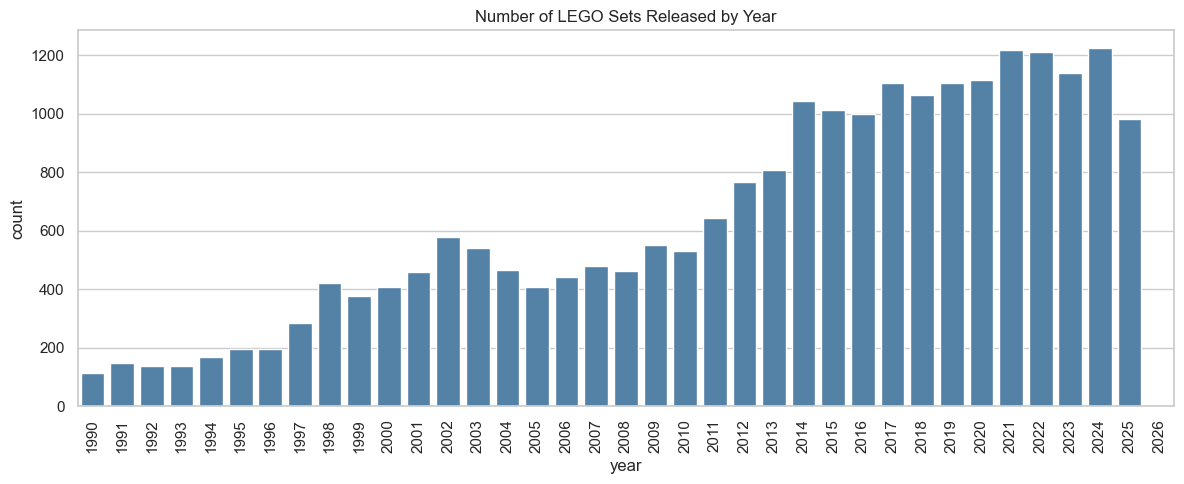

year
2017    1104
2018    1065
2019    1106
2020    1115
2021    1219
2022    1210
2023    1141
2024    1224
2025     981
2026       4
Name: set_num, dtype: int64


In [3]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x="year", color="steelblue")
plt.xticks(rotation=90)
plt.title("Number of LEGO Sets Released by Year")
plt.tight_layout(); plt.show()

print(df.groupby("year")["set_num"].nunique().tail(10))

## 3) Univariate — Set size distribution
Part count is the most obvious price driver candidate.

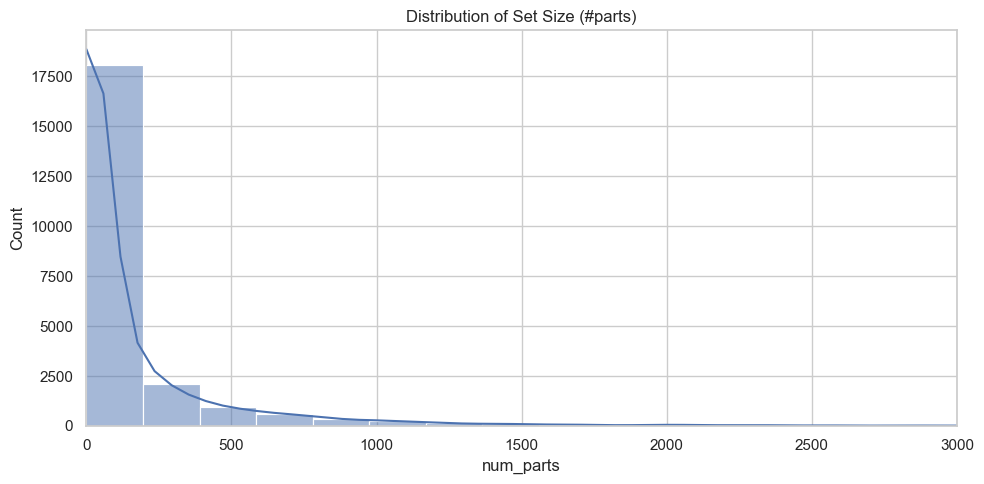

count    22955.000000
mean       173.569767
std        450.743408
min          0.000000
25%          0.000000
50%         26.000000
75%        145.000000
max      11695.000000
Name: num_parts, dtype: float64

In [4]:
plt.figure(figsize=(10,5))
sns.histplot(df["num_parts"], bins=60, kde=True)
plt.xlim(0, 3000)  # trim extreme tails for readability
plt.title("Distribution of Set Size (#parts)")
plt.tight_layout(); plt.show()

df["num_parts"].describe()

## 4) Univariate — Top themes by volume
Which themes dominate the catalog?

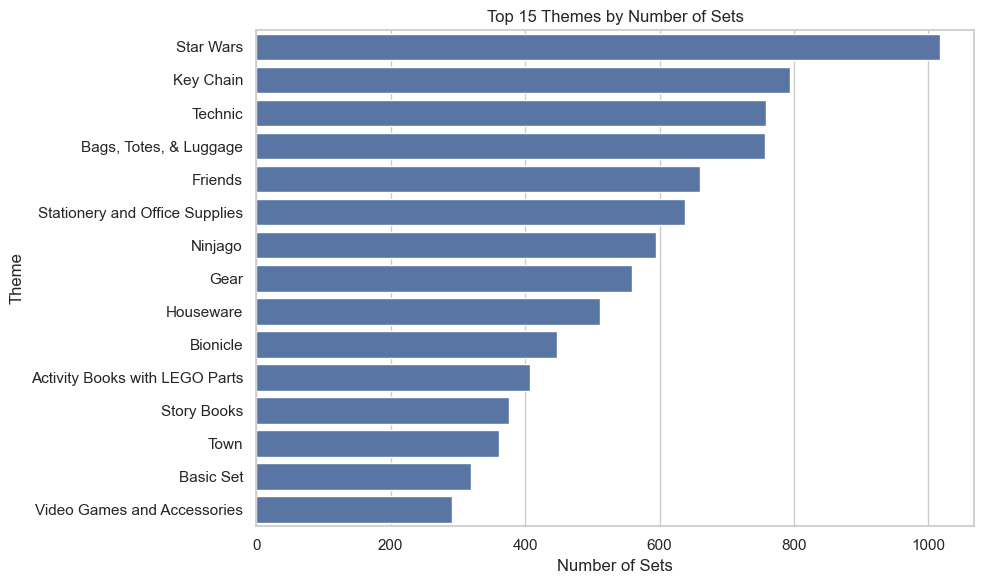

In [5]:
top_themes = df["theme_name"].value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_themes.values, y=top_themes.index)
plt.title("Top 15 Themes by Number of Sets")
plt.xlabel("Number of Sets"); plt.ylabel("Theme")
plt.tight_layout(); plt.show()

## 5) Bivariate — Parts by theme
Do some themes consistently release larger builds?

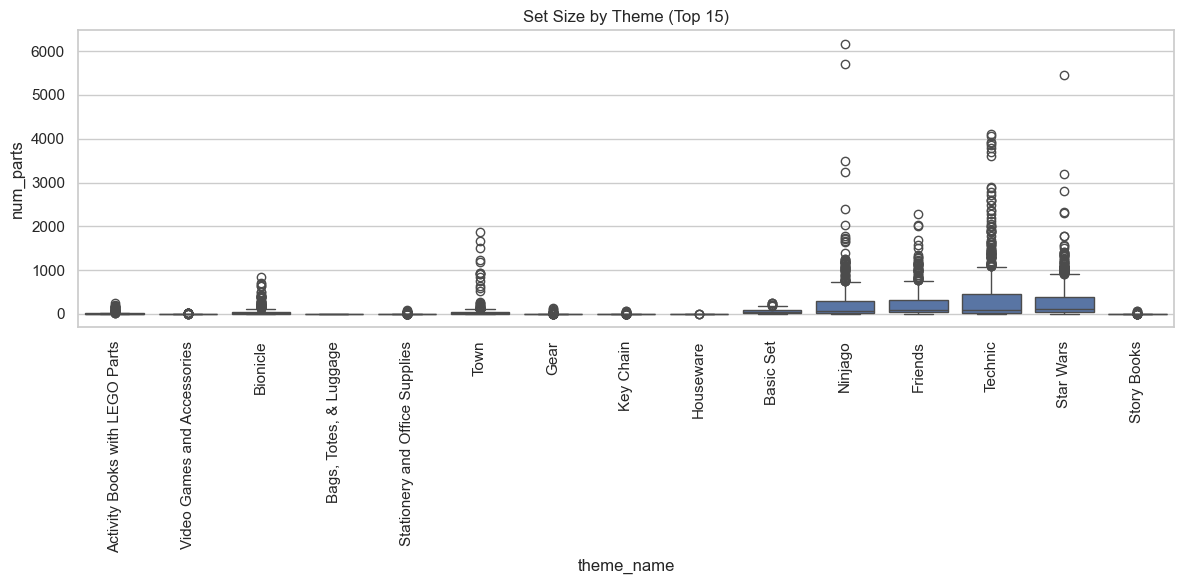

In [6]:
subset = df[df["theme_name"].isin(top_themes.index)]
plt.figure(figsize=(12,6))
sns.boxplot(data=subset, x="theme_name", y="num_parts")
plt.xticks(rotation=90)
plt.title("Set Size by Theme (Top 15)")
plt.tight_layout(); plt.show()

## 6) Bivariate — Average set size over time
Are sets getting bigger?

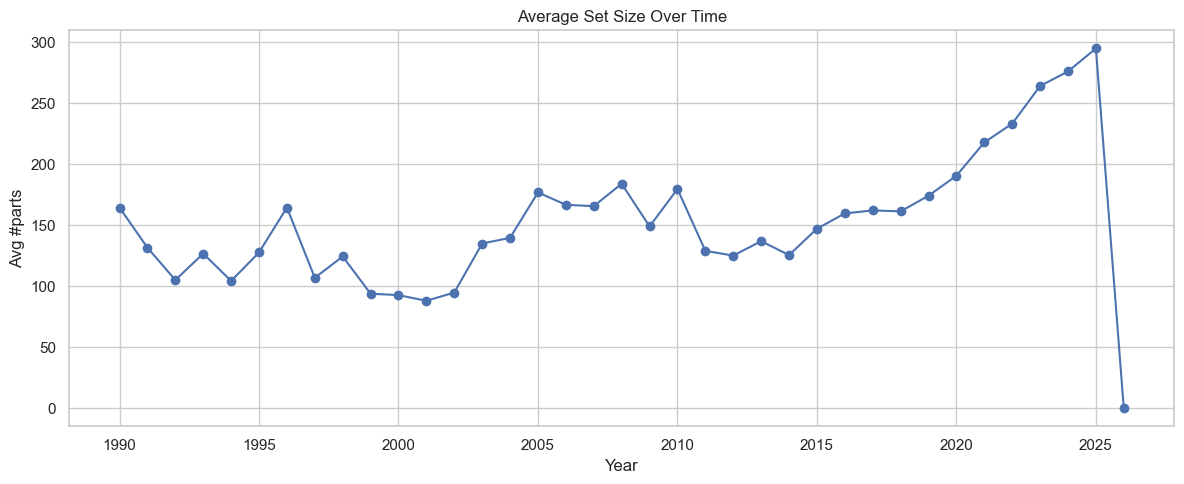

year
2017    162.140399
2018    161.356808
2019    174.178119
2020    190.559641
2021    217.858901
2022    233.240496
2023    264.111306
2024    276.035948
2025    294.904179
2026      0.000000
Name: num_parts, dtype: float64

In [7]:
avg_parts_per_year = df.groupby("year")["num_parts"].mean()
plt.figure(figsize=(12,5))
avg_parts_per_year.plot(marker="o")
plt.title("Average Set Size Over Time")
plt.ylabel("Avg #parts"); plt.xlabel("Year")
plt.tight_to_layout = plt.tight_layout(); plt.show()

avg_parts_per_year.tail(10)

## 7) Simple statistical check

**Question:** Do the largest themes (by volume) differ in average part counts?

Approach: one‑way **ANOVA** across a few major themes.
Caveat: ANOVA assumes normality/variance homogeneity; we treat this as a directional check, not a publication.

In [ ]:
import scipy.stats as st

majors = ["Star Wars", "Technic", "City", "Creator", "Ninjago"]
majors = [t for t in majors if t in df["theme_name"].unique()]

samples = [df.loc[df["theme_name"]==t, "num_parts"].dropna() for t in majors]
anova = st.f_oneway(*samples) if len(samples) >= 2 else None
print("Themes tested:", majors)
print("ANOVA F-stat, p-value:", getattr(anova, "statistic", None), getattr(anova, "pvalue", None))

## 8) Feature ideas (for price prediction)

- **num_parts** (numeric) — strong primary driver
- **theme_name** (categorical → one‑hot / target encode)
- **year** (numeric; consider non‑linear trend or bucket by era)
- **minifigs_count** (if available from inventories)
- **rarity signals** (limited releases, retired flag if you can source it)

**Next:** ingest **BrickLink resale prices**, join on `set_num`, and train a baseline regression (XGBoost/LightGBM).